In [2]:
# import modules
import os.path
from gensim import corpora
from gensim.models import LdaModel
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# reading files
dfdat1 = pd.read_csv('2021VAERSDATA.csv', index_col=None, header=0, dtype = 'object', encoding= 'latin1')
dfvax1 = pd.read_csv('2021VAERSVAX.csv', index_col=None, header=0, dtype = 'object', encoding= 'latin1')
dfdat2 = pd.read_csv('2022VAERSDATA.csv', index_col=None, header=0, dtype = 'object', encoding= 'latin1')
dfvax2 = pd.read_csv('2022VAERSVAX.csv', index_col=None, header=0, dtype = 'object', encoding= 'latin1')

In [5]:
# merging dataframes
df1_merged = dfvax1.merge(dfdat1, how = 'outer', on = 'VAERS_ID')
df2_merged = dfvax2.merge(dfdat2, how = 'outer', on = 'VAERS_ID')

df = pd.concat([df1_merged, df2_merged], axis=0)

# extracting desired columns
df = df.loc(axis=1)['VAX_MANU','SYMPTOM_TEXT']

In [6]:
def clean_data(doc_set):
    """
    Input: document list
    Purpose: preprocess text (tokenize, remove stopwords, stemming)
    Output: cleaned text
    """

    tokenizer = RegexpTokenizer(r'\w+')

    # create English stop words list
    en_stop = nltk.corpus.stopwords.words('english')

    # adding new stop words
    new_stopwords = ['could', 'within', 'us', 'doctor', 'medical', 'day', 'moderna', 'pfizer', 'patient', 'vaccine', 
                 'report', 'gsk', 'janssen', 'merck', 'get', 'got', 'lot', 'left', 'right','like','went','take', 
                 'note', 'notes', 'given', 'receive', 'unspecific', 'unspecified','unknown','reporting', 'pt','non',
                 'caller','number', 'state','call', 'start','feel', 'date', 'reporter','administered', 'dose', 'season',
                 'go','day','still','includ','data','laboratori', 'minut','receiv','admin','condit','caus','consid',
                 'inform','comment','ye','clinic','outcom','vaccin', 'medic','administ','administr','symptom']

    # Create p_stemmer of class PorterStemmer
    p_stemmer = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem

    # list for tokenized documents in loop
    texts = []

    # replace empty cells with stopword
    #dfpbt = dfpbt.replace('void', 'the')
    #dfpbt = dfpbt.fillna('the')

    # loop through document list
    for i in doc_set:

        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)

        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop] 

        # remove numbers from tokens    
        letter_tokens = [i for i in stopped_tokens if not any(filter(str.isdigit, i))]

        # stem tokens
        stemmed_tokens = [p_stemmer(i) for i in letter_tokens]

        # remove stop words from tokens
        new_tokens = [i for i in stemmed_tokens if not i in new_stopwords] 

        # lemmatize tokens
        #lemma_tokens = [lemmatizer.lemmatize(i) for i in letter_tokens]

        # add tokens to list
        texts.append(new_tokens)
        
    return texts

In [7]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

def create_gensim_lda_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LDA model using gensim
    Output : return LDA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LDA model
    ldamodel = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary, passes=10)  # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return ldamodel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LDA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LdA model
        #model = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary, passes=10)
        model = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary, passes=10) # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
    
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()


In [8]:
from collections import Counter

# Function to generate Wordcloud of Top N words in each topic

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def lda_wordcloud(ldamodel):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(background_color='white',
                      width=2000,
                      height=1000,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = ldamodel.show_topics(formatted=False)

    fig, axes = plt.subplots(1,len(topics), figsize=(8,8), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=14))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

In [9]:
## GSK
dfgsk = df[df['VAX_MANU'] == 'MERCK & CO. INC.'].reset_index(drop=True)
dfgsk = dfgsk.astype(str)
dfgsk = dfgsk.drop_duplicates()
clean_gsk = clean_data(dfgsk['SYMPTOM_TEXT'])

# LDA Model
number_of_topics = 5
words = 10
gskmodel = create_gensim_lda_model(clean_gsk,number_of_topics,words)

[(0, '0.016*"arm" + 0.015*"pain" + 0.011*"inject" + 0.010*"site" + 0.010*"red" + 0.009*"rash" + 0.009*"swell" + 0.008*"fever" + 0.007*"mother" + 0.006*"child"'), (1, '0.028*"event" + 0.026*"gardasil" + 0.025*"year" + 0.024*"provid" + 0.023*"old" + 0.020*"expir" + 0.019*"hpv" + 0.017*"rout" + 0.016*"prophylaxi" + 0.016*"histori"'), (2, '0.067*"syring" + 0.026*"broken" + 0.020*"attach" + 0.016*"product" + 0.015*"needl" + 0.013*"crack" + 0.013*"detail" + 0.012*"provid" + 0.012*"describ" + 0.012*"case"'), (3, '0.033*"expir" + 0.027*"temperatur" + 0.024*"excurs" + 0.024*"addit" + 0.024*"advers" + 0.022*"provid" + 0.021*"event" + 0.021*"live" + 0.018*"viru" + 0.017*"ae"'), (4, '0.038*"zoster" + 0.024*"live" + 0.022*"zostavax" + 0.021*"result" + 0.018*"injuri" + 0.018*"suffer" + 0.015*"event" + 0.014*"shingl" + 0.014*"relat" + 0.012*"loss"')]


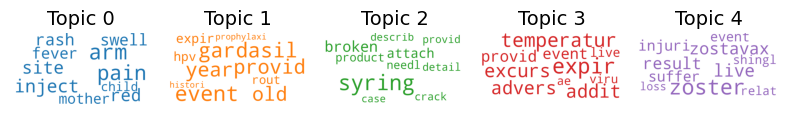

In [10]:
lda_wordcloud(gskmodel)

#### lda_keywords(gskmodel)

In [70]:
## MODERNA
dfmoderna = df[df['VAX_MANU'] == 'MODERNA'].reset_index(drop=True)
dfmoderna = dfmoderna.astype(str)
dfmoderna = dfmoderna.drop_duplicates()
clean_moderna = clean_data(dfmoderna['SYMPTOM_TEXT'])

# LDA Model
number_of_topics = 5
words = 10
modernamodel = create_gensim_lda_model(clean_moderna,number_of_topics,words)

### easy way to convert models into matrices/dfs

[(0, '0.065*"covid" + 0.043*"mrna" + 0.039*"event" + 0.037*"product" + 0.027*"advers" + 0.024*"temperatur" + 0.021*"excurs" + 0.021*"experienc" + 0.021*"case" + 0.020*"dosag"'), (1, '0.069*"pain" + 0.038*"headach" + 0.037*"fever" + 0.037*"fatigu" + 0.024*"chill" + 0.024*"sore" + 0.020*"ach" + 0.019*"arm" + 0.018*"felt" + 0.017*"bodi"'), (2, '0.036*"bival" + 0.024*"covid" + 0.020*"ba" + 0.020*"test" + 0.013*"posit" + 0.010*"hospit" + 0.010*"origin" + 0.009*"blood" + 0.007*"booster" + 0.006*"neg"'), (3, '0.099*"site" + 0.079*"inject" + 0.078*"arm" + 0.050*"rash" + 0.044*"pain" + 0.040*"swell" + 0.037*"red" + 0.021*"itch" + 0.021*"sore" + 0.019*"swollen"'), (4, '0.019*"week" + 0.014*"shot" + 0.014*"pain" + 0.012*"back" + 0.010*"side" + 0.010*"booster" + 0.009*"leg" + 0.008*"eye" + 0.008*"also" + 0.008*"time"')]


In [37]:
modernamodel_ = [(0, '0.077*"mod" + 0.070*"refriger" + 0.061*"store" + 0.030*"dosag" + 0.025*"eye" + 0.022*"allergi" + 0.017*"oral" + 0.017*"hive" + 0.015*"failur" + 0.015*"rash"'), (1, '0.062*"bival" + 0.041*"booster" + 0.035*"occurr" + 0.035*"ba" + 0.023*"week" + 0.022*"advers" + 0.018*"origin" + 0.017*"issu" + 0.017*"month" + 0.013*"second"'), (2, '0.131*"site" + 0.105*"inject" + 0.069*"arm" + 0.048*"red" + 0.046*"rash" + 0.033*"swell" + 0.024*"clean" + 0.021*"sore" + 0.019*"pain" + 0.018*"itch"'), (3, '0.305*"mrna" + 0.055*"intramuscular" + 0.040*"seriou" + 0.031*"humira" + 0.031*"nov" + 0.028*"adalimumab" + 0.026*"may" + 0.025*"signific" + 0.024*"benefit" + 0.018*"resolv"'), (4, '0.065*"rout" + 0.018*"heart" + 0.016*"hospit" + 0.016*"breath" + 0.013*"home" + 0.012*"chest" + 0.012*"discharg" + 0.011*"present" + 0.010*"room" + 0.009*"short"'), (5, '0.073*"temperatur" + 0.069*"headach" + 0.068*"fever" + 0.067*"fatigu" + 0.044*"poor" + 0.043*"chill" + 0.036*"ach" + 0.031*"degre" + 0.029*"bodi" + 0.024*"pain"'), (6, '0.047*"hour" + 0.036*"felt" + 0.021*"move" + 0.020*"took" + 0.019*"punctur" + 0.015*"back" + 0.015*"bad" + 0.014*"night" + 0.014*"next" + 0.013*"time"'), (7, '0.077*"dosag" + 0.075*"covid" + 0.054*"test" + 0.041*"posit" + 0.027*"link" + 0.024*"omicron" + 0.024*"storag" + 0.018*"oct" + 0.017*"blood" + 0.016*"neg"'), (8, '0.086*"covid" + 0.056*"event" + 0.054*"product" + 0.031*"excurs" + 0.031*"advers" + 0.030*"case" + 0.029*"experienc" + 0.026*"provid" + 0.026*"temperatur" + 0.024*"expir"'), (9, '0.126*"pain" + 0.041*"arm" + 0.037*"arthriti" + 0.021*"leg" + 0.020*"back" + 0.018*"sore" + 0.018*"extrem" + 0.016*"hand" + 0.014*"shoulder" + 0.014*"psoriasi"')]

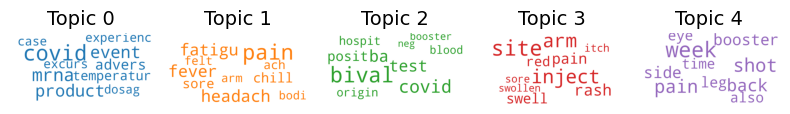

In [73]:
lda_wordcloud(modernamodel)

In [ ]:
## PFIZER\BIONTECH
dfpbt = df[df['VAX_MANU'] == 'PFIZER\BIONTECH'].reset_index(drop=True)
dfpbt = dfpbt.astype(str)
dfpbt = dfpbt.drop_duplicates()
clean_pbt = clean_data(dfpbt['SYMPTOM_TEXT'])

# LDA Model
number_of_topics = 5
words = 10
clean_text = clean_pbt
model = create_gensim_lda_model(clean_text,number_of_topics,words)